# Tracer des cas de Cholera à Londres

Charger les modules utiles

In [1]:
import folium # librairie pour afficher les cartes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# les données

Source : http://blog.rtwilson.com/john-snows-cholera-data-in-more-formats/  
KLM data ZIP file: http://rtwilson.com/downloads/SnowGIS_KML.zip

Le dossier dezippé contient les données pumps et death dans des fichiers au format kml.

Là j'avais 2 choix : utiliser une bibliothèque pour lire les kml (plus simple) ou coder un lecteur. Je n'ai pas réussi à installer pykml, ni fastkml ... J'ai donc du aller sur l'option code.

Les fichiers kml sont des fichiers texte (xml) et les informations dont nous avons besoin sont encadrées dans des balises (coordinates et value pour les deaths).

Le principe de mon code est de lire le fichier texte, puis chercher les balises. Je fais l'hypothèse que le fichier a été généré par un code et sera donc avec un format très régulier (pas d'exception).  Le nombre de charactères à enlever avant et après sera donc le même pour chaque ligne. Cette hypothèse se vérifie et permet de simplifier le code en utilisant le slicing (str[35:34] par ex).


## fonction pour lire les données

Comme il y a 2 fichiers à traiter, je crée une petite fonction qui me renvoie les informations. Si on ne trouve rien cela renvoie un tableau vide (cas du nb de morts pour les pompes)

In [2]:
def read_kml(fname):
    # lit un fichier et extrait les informations pertinentes
    nb = [] # nb de morts
    lat =[] 
    long= []
    with open(fname) as f :
        for line in f :
            if "value" in line:
                # ligne avec valeur, on enlève les tabuluations et espaces, les balises et il reste une string à convertir en int
                # ex : (tab) <value>2</value>
                valeur = line.strip()[7:-8]
                nb.append(valeur)
            if "coordinates" in line:
                # ligne avec coordiates, on enlève les tabuluations et espaces, et on coupe pour encadrer les coordonnées
                # ex: ...<coordinates>-0.137883,51.513361</coordinates>...
                coord = line.strip()[35:-34]
                x,y = coord.split(',')
                lat.append(float(x))
                long.append(float(y))

    return lat,long,nb
        


## fichier des victimes

J'appelle la fonction, réorganise les données pour en faire un dataframe et je vérifie à la fin que les longitudes et latitudes mini et maxi sont proches. Cela valide mon hypothèse de format régulier.
On verra dans la visualisation que ces coordonnées sont bien à londres et qu'il y a une bien une pompe à la pompe de Broad Street.

In [3]:
fname = 'cholera_deaths.kml'
lat,long,nb = read_kml(fname)

# dans ce cas il y a un nb de vitimes
data = [[a,b,c] for a,b,c in zip (lat,long,nb)]
victimes = pd.DataFrame(data = data, columns = ['lat', 'long','nb'])

# verification
print(f"Lat min {victimes.lat.min()}, Lat max {victimes.lat.max()}")
print(f"Long min {victimes.long.min()}, Long max {victimes.long.max()}")

Lat min -0.140074, Lat max -0.132933
Long min 51.511856, Long max 51.515834


## fichier des pompes

Idem mais sans les données sur le nombre qui sont "vides"

In [4]:
fname = 'pumps.kml'
lat,long,nb = read_kml(fname)

# dans ce cas il y a un nb de vities
data = [[a,b] for a,b in zip (lat,long)]
pompes = pd.DataFrame(data = data, columns = ['lat', 'long'])

# verification
print(f"Lat min {pompes.lat.min()}, Lat max {pompes.lat.max()}")
print(f"Long min {pompes.long.min()}, Long max {pompes.long.max()}")

Lat min -0.139671, Lat max -0.13163
Long min 51.510019, Long max 51.514906


# tracer sur une carte

Nous allons commencer par afficher la carte en la centrant sur le centre des victimes.
Puis afficher les pompes (en cercle bleu rempli) et les victimes (en cercle rouge).

Nous utilisons la librairie Folium : https://python-visualization.github.io/folium/quickstart.html

In [5]:
# création de la carte au bon endroit avec
latcentre = victimes.lat.mean()
longcentre = victimes.long.mean()
m = folium.Map(location=[longcentre,latcentre],zoom_start=17)

# Ajout des pompes
for i in pompes.index:
    folium.Circle(
    radius=10,
    location=[pompes.loc[i,'long'], pompes.loc[i,'lat']],
    popup='Une pompe',
    color='blue',
    fill=True,
    ).add_to(m)
    
# Ajout des victimes
for i in victimes.index:
    folium.Circle(
    radius=1*victimes.loc[i,'nb'],
    location=[victimes.loc[i,'long'], victimes.loc[i,'lat']],
    popup=f"{victimes.loc[i,'long']} victime(s)",
    color='crimson',
    fill=True,
    ).add_to(m)
    
# affichage de la carte
m

Une des pompes est clairement au centre du nuage des victimes

# Analyse des données

Je vais calculer pour chaque pompe, la distance des victimes et produire des histogrammes.
Pour le calcul de distance, je crée une fonction distance basée sur une métrique euclidienne avec un coefficient pour renormer les chiffres vers 10. Les valeurs n'ont pas d'importance, ce qui compte c'est les écarts.

J'utilise ensuite la propriété de broadcast de python pour ajouter en une seule étape de nouvelles colonnes au tableau victime qui donnent la distance de chaque victime à la pompe i et appelée "disp_p_i"

In [6]:
def distance(lx,ly,px,py):
    # calcul la distance entre une victime (lx,ly) et une pompe px,py
    # renormalisation pour avoir des valeurs vers 10-100
    return np.sqrt((lx-px)**2 + (ly-py)**2)*1e5

listenom = []
for i in pompes.index:
    px = pompes.long[i]
    py = pompes.lat[i]
    nom ='dist_p_'+str(i)
    listenom.append(nom)
    victimes[nom] = distance(victimes['long'],victimes['lat'],px,py)



Nous pouvons ensuite calculer des moyennes des distances et classer les pompes par leur distance moyenne aux victimes. La pompe 0 sort comme étant la plus près et très différente des autres.


In [7]:
liste = victimes[listenom].mean().sort_values()
print(liste)


dist_p_0    156.593215
dist_p_5    245.268351
dist_p_7    305.985814
dist_p_4    331.793288
dist_p_1    332.777545
dist_p_2    375.920828
dist_p_6    442.980035
dist_p_3    499.486337
dtype: float64


Ce qui se confirme sur l'histogramme.


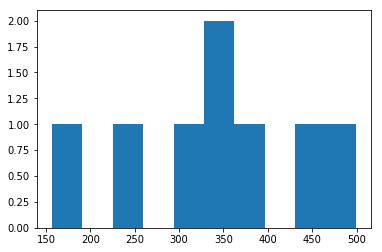

In [8]:
plt.hist(liste)
plt.show()

Un dernier graphique pour affichier les densités cumulées des distances des victimes pour les 7 pompes. On retrouve que les victimes sont plus proches de la pompe 0.

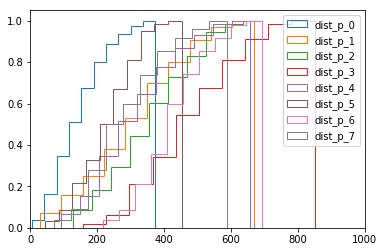

In [9]:
for i in listenom:
    plt.hist(victimes[i], cumulative = True, histtype ='step',label = i, density = True)
plt.legend()
plt.xlim(0,1000)
plt.show()